In [14]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import string
import re

In [15]:
df = pd.read_csv('European Restaurant Reviews.csv')

In [16]:
df.head()

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...


In [17]:
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mData types of columns:\033[0m\n", df.dtypes)
    
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    
    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")
        
    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())
    
    print("\n\033[1mNumber of duplicate rows:\033[0m ", df.duplicated().sum())
    
    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n",) 
    
    return df.describe().transpose()

# Call the function
get_df_info(df)


Shape of DataFrame:  (1502, 6)

Columns in DataFrame:  ['Country', 'Restaurant Name', 'Sentiment', 'Review Title', 'Review Date', 'Review']

Data types of columns:
 Country            object
Restaurant Name    object
Sentiment          object
Review Title       object
Review Date        object
Review             object
dtype: object

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          1502 non-null   object
 1   Restaurant Name  1502 non-null   object
 2   Sentiment        1502 non-null   object
 3   Review Title     1502 non-null   object
 4   Review Date      1502 non-null   object
 5   Review           1502 non-null   object
dtypes: object(6)
memory usage: 70.5+ KB

Number of unique values in each column:
Country: 7
Restaurant Name: 7
Sentiment: 2
Review Title: 1343
Review Date: 143
Review:

,count,unique,top,freq
Country,1502,7,France,512
Restaurant Name,1502,7,The Frog at Bercy Village,512
Sentiment,1502,2,Positive,1237
Review Title,1502,1343,Excellent,9
Review Date,1502,143,May 2014 •,108
Review,1502,1426,I'm afraid we were very let down by this resta...,4


In [20]:
df = df.drop_duplicates()


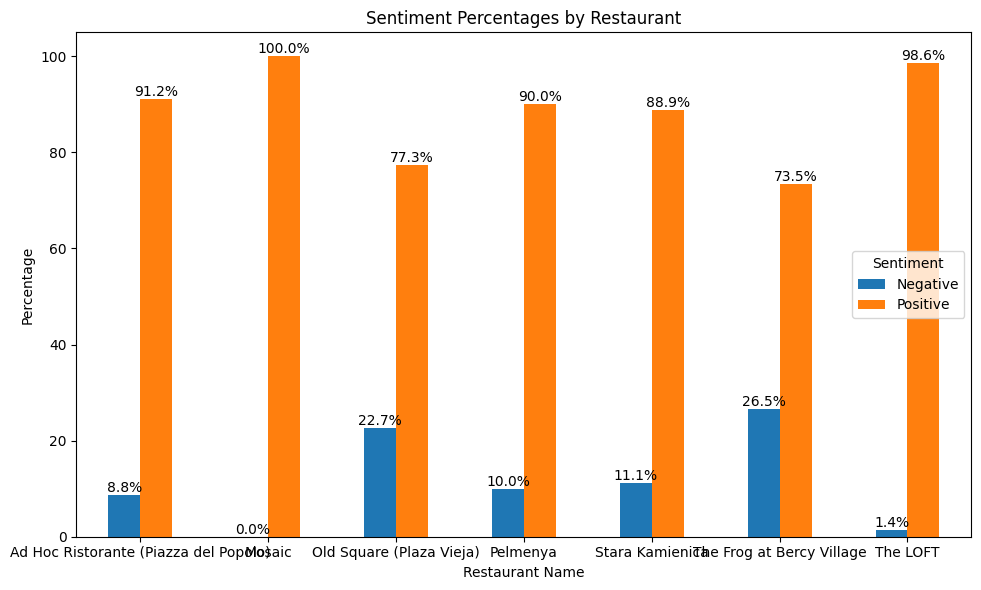

In [21]:
# Calculate the percentage of each sentiment for each restaurant
sentiment_percentages = df.groupby('Restaurant Name')['Sentiment'].value_counts(normalize=True).unstack() * 100

# Create a grouped bar plot
ax = sentiment_percentages.plot(kind='bar', figsize=(10, 6))

# Customize the plot
plt.title('Sentiment Percentages by Restaurant')
plt.xlabel('Restaurant Name')
plt.ylabel('Percentage')
plt.legend(title='Sentiment')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability

# Add percentage labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

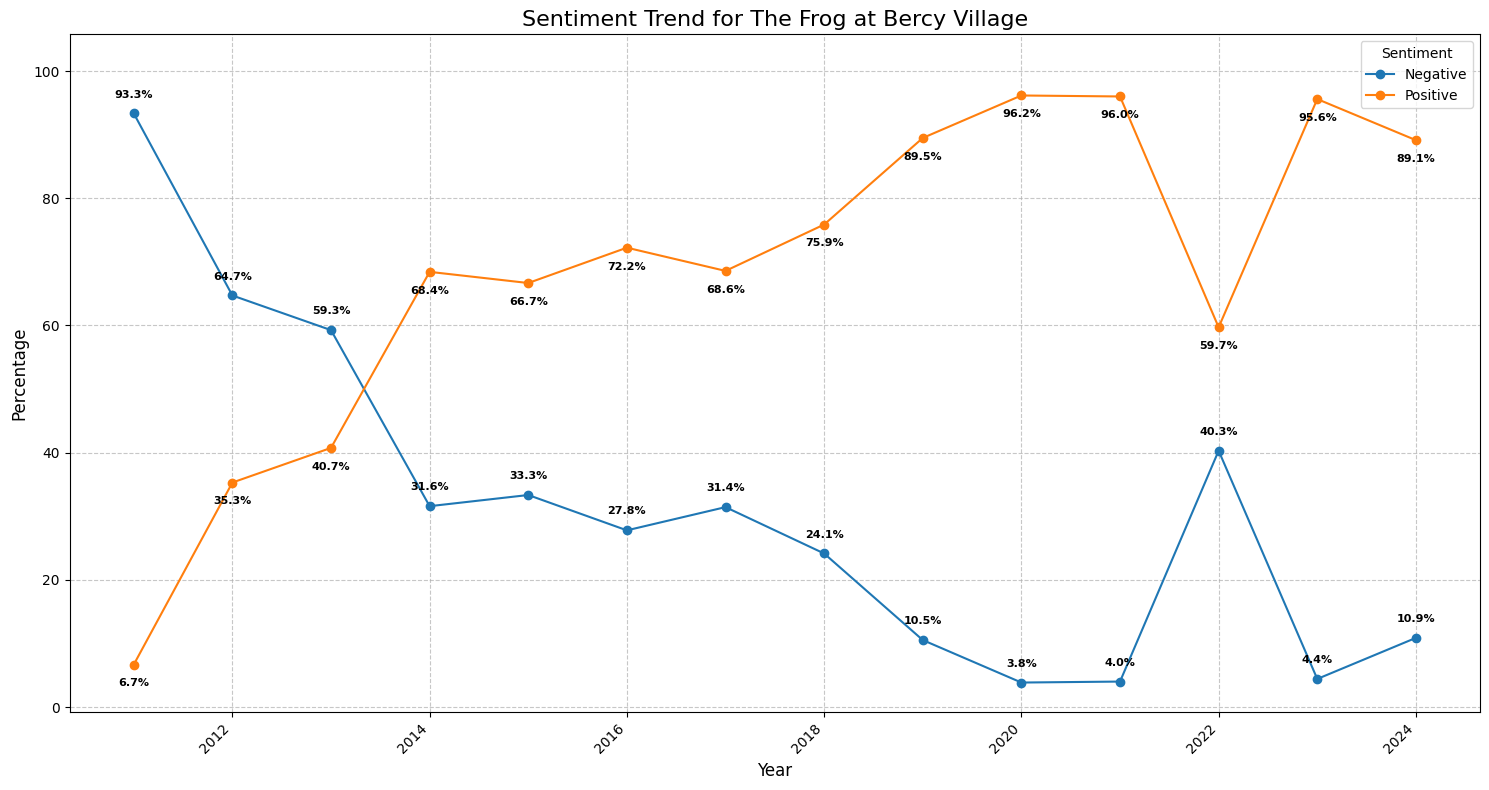

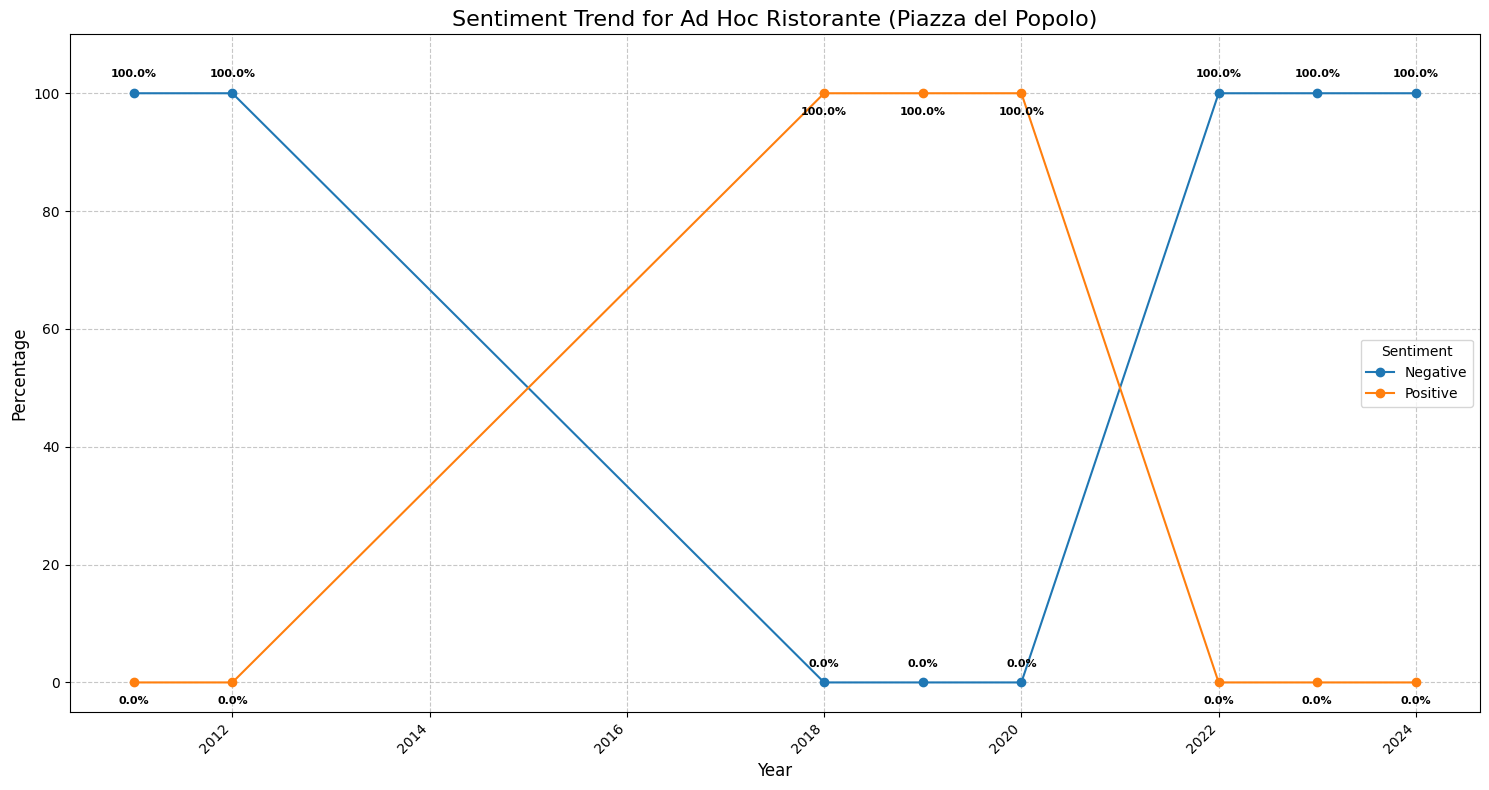

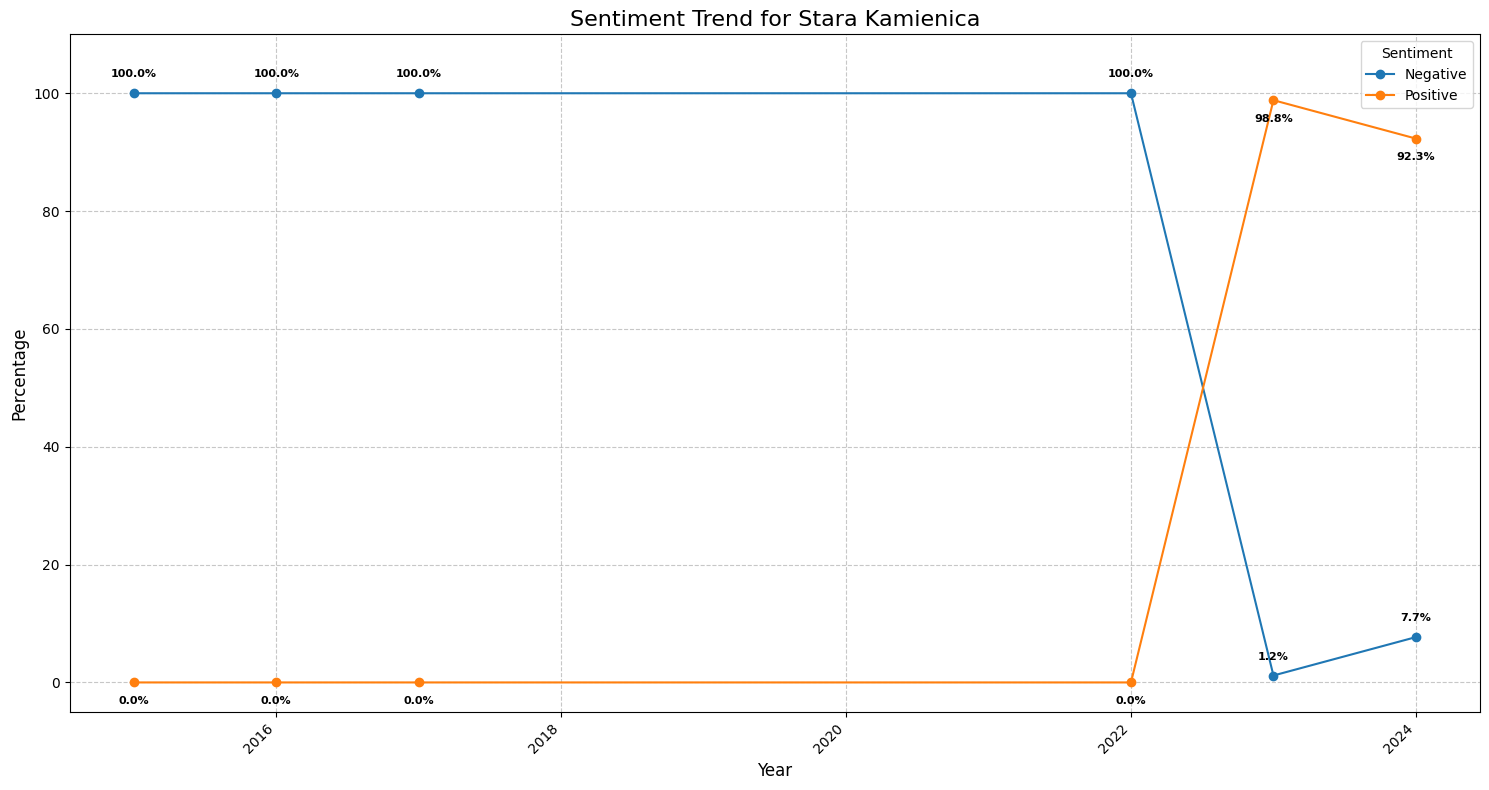

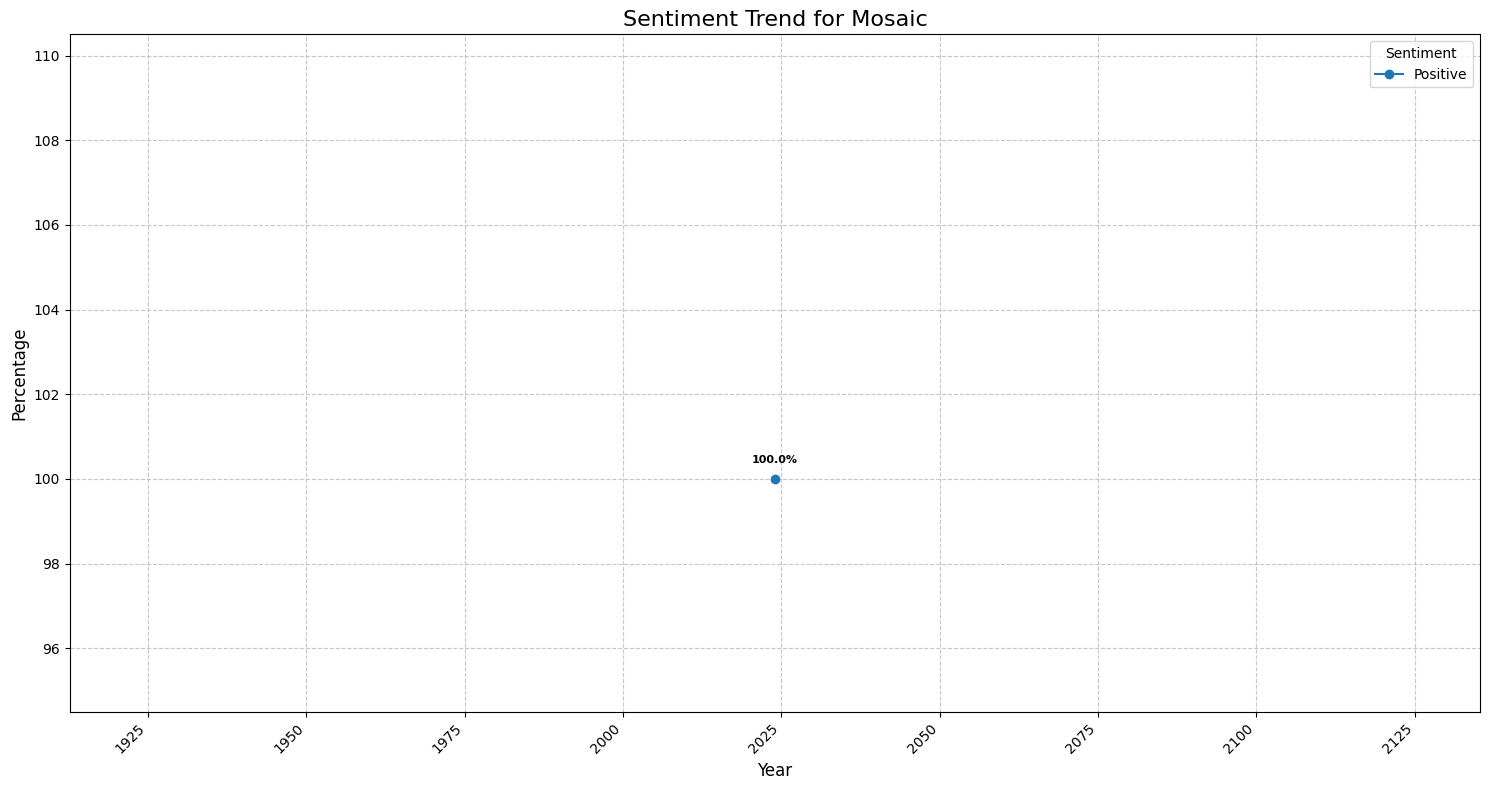

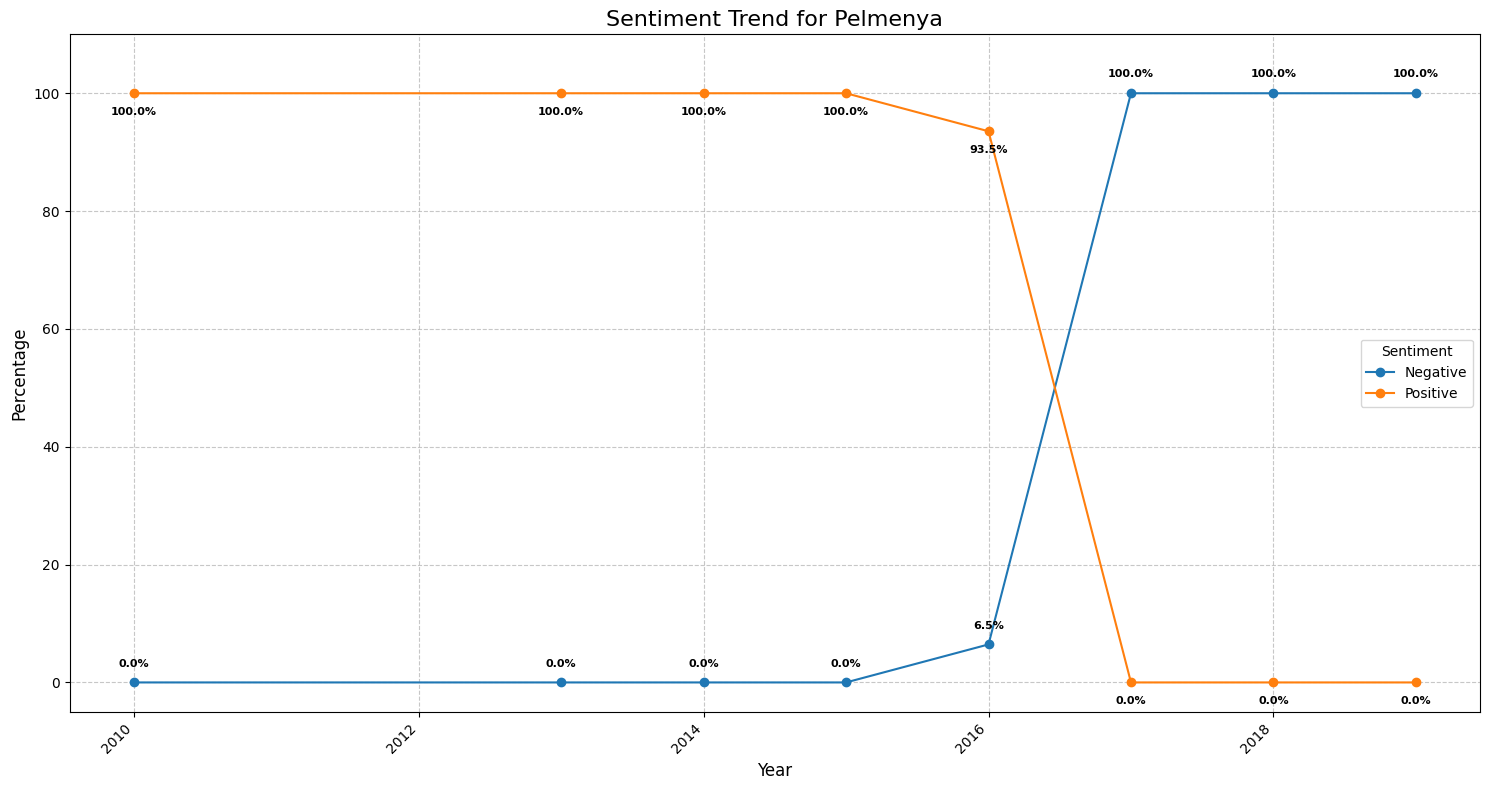

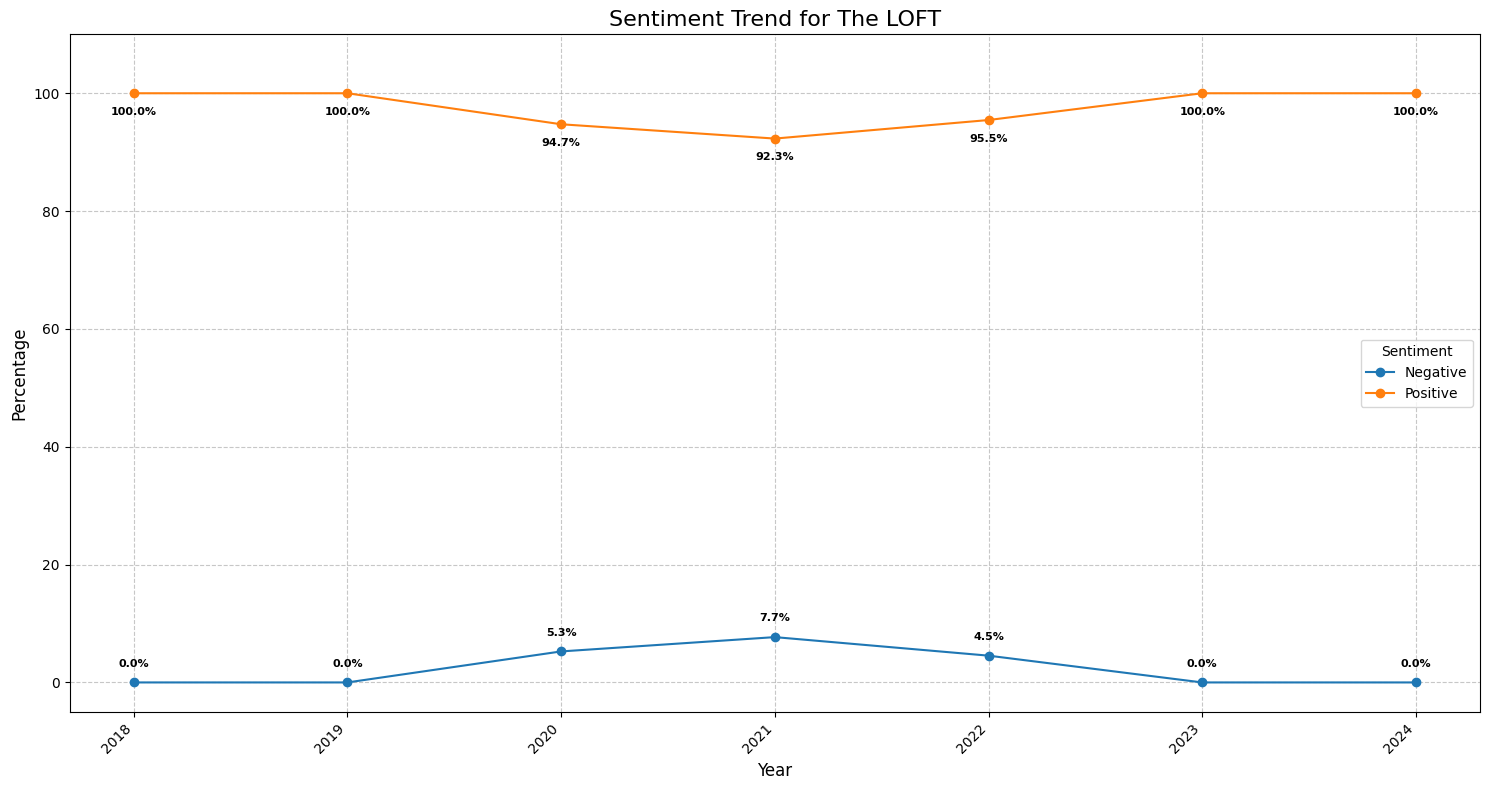

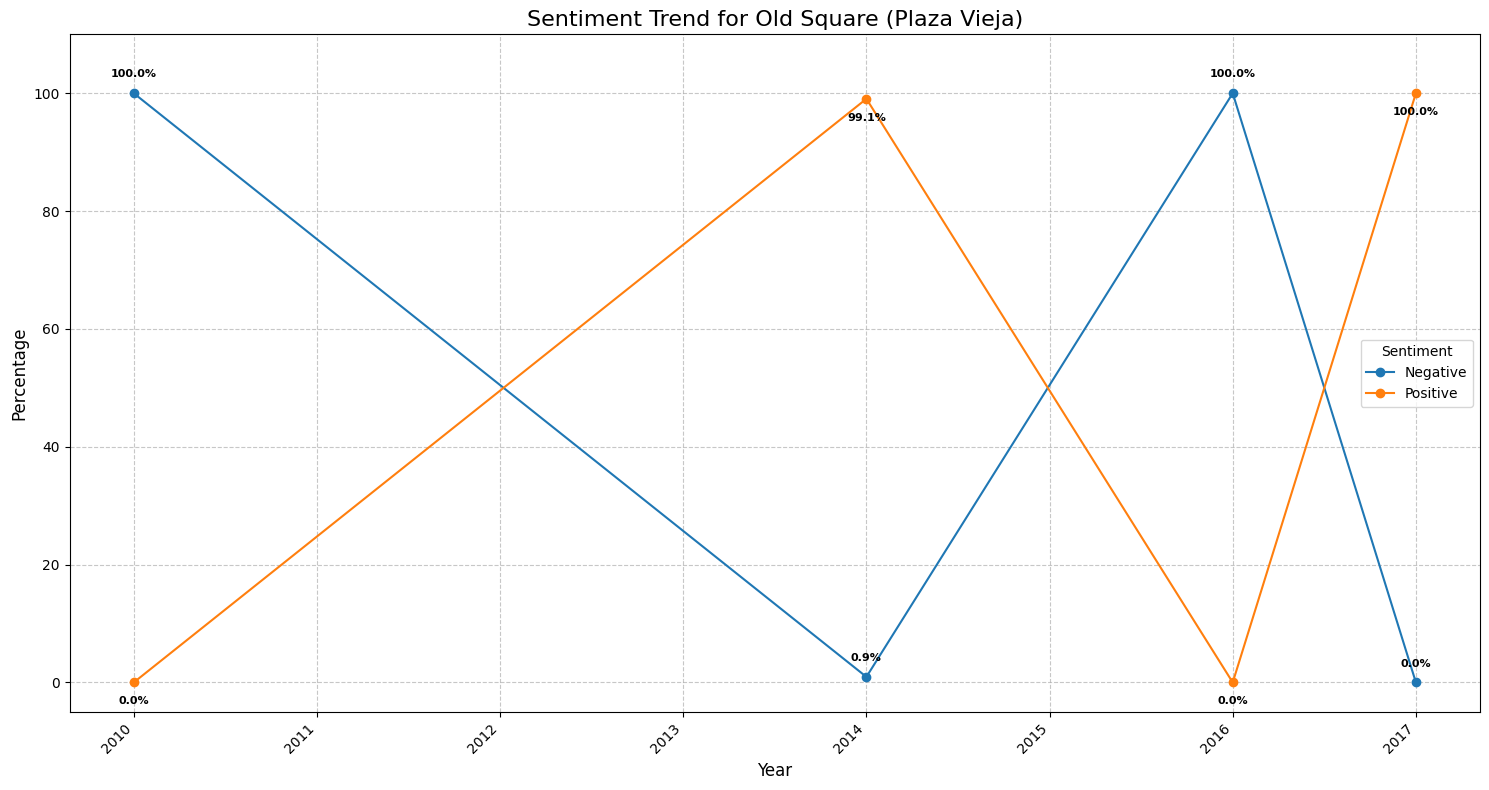

In [22]:
from datetime import datetime

def clean_date(date_str):
    date_str = date_str.replace(' •', '').strip()
    # Handle 'Sept' special case
    if date_str.startswith('Sept'):
        date_str = date_str.replace('Sept', 'Sep')
    try:
        return datetime.strptime(date_str, '%b %Y').strftime('%Y-%m')
    except ValueError:
        # If the above fails, try with full month name
        return datetime.strptime(date_str, '%B %Y').strftime('%Y-%m')

# Clean the 'Review Date' column
df['Clean Date'] = df['Review Date'].apply(clean_date)

# Extract year from the cleaned date
df['Year'] = pd.to_datetime(df['Clean Date']).dt.year

# Function to create plot for each restaurant
def plot_sentiment_over_time(restaurant_df, restaurant_name):
    # Group by year and sentiment, count occurrences
    yearly_sentiment = restaurant_df.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)
    
    # Calculate percentages
    yearly_sentiment_pct = yearly_sentiment.div(yearly_sentiment.sum(axis=1), axis=0) * 100
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 8))
    yearly_sentiment_pct.plot(kind='line', marker='o', ax=ax)
    
    plt.title(f'Sentiment Trend for {restaurant_name}', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.legend(title='Sentiment', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add percentage labels on the points with improved positioning
    for i, column in enumerate(yearly_sentiment_pct.columns):
        for x, y in zip(yearly_sentiment_pct.index, yearly_sentiment_pct[column]):
            va = 'bottom' if i == 0 else 'top'  # Alternate vertical alignment
            xytext = (0, 10) if i == 0 else (0, -10)  # Alternate vertical offset
            ax.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=xytext, 
                        ha='center', va=va, fontsize=8, fontweight='bold')
    
    # Adjust y-axis to give some headroom for labels
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + 5)
    
    plt.tight_layout()
    plt.show()

# Get unique restaurant names
restaurants = df['Restaurant Name'].unique()

# Create plots for each restaurant
for restaurant in restaurants:
    restaurant_df = df[df['Restaurant Name'] == restaurant]
    plot_sentiment_over_time(restaurant_df, restaurant)

In [23]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]
    cleaned_text = ' '.join(tokens)
    cleaned_text = re.sub('\s+', ' ', cleaned_text).strip()
    return cleaned_text

def apply_models(df, text_column, target_column):
    # Clean text
    df['Cleaned_Text'] = df[text_column].apply(clean_text)

    # Split the data into features (X) and target (y)
    X = df['Cleaned_Text']
    y = df[target_column]

    # Initialize the TfidfVectorizer
    tfidf = TfidfVectorizer(max_features=5000)

    # Initialize the LabelEncoder
    le = LabelEncoder()

    # Fit the encoder on the entire dataset
    y = le.fit_transform(y)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit and transform the TF-IDF vectorizer
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    # Check for class imbalance
    class_counts = np.bincount(y_train)
    if len(class_counts) > 2 or np.min(class_counts) / np.max(class_counts) < 0.1:
        print("Class imbalance detected. Applying SMOTE...")
        smote = SMOTE(random_state=42)
        X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)

    # Define the models
    models = {
        'LogisticRegression': OneVsRestClassifier(LogisticRegression()),
        'SVC': OneVsRestClassifier(SVC()),
        'DecisionTree': OneVsRestClassifier(DecisionTreeClassifier()),
        'RandomForest': OneVsRestClassifier(RandomForestClassifier()),
        'ExtraTrees': OneVsRestClassifier(ExtraTreesClassifier()),
        'AdaBoost': OneVsRestClassifier(AdaBoostClassifier()),
        'GradientBoost': OneVsRestClassifier(GradientBoostingClassifier()),
        'XGBoost': OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        'LightGBM': OneVsRestClassifier(LGBMClassifier(verbose=-1)),
        'CatBoost': OneVsRestClassifier(CatBoostClassifier(verbose=0))
    }

    # Initialize a dictionary to hold the performance of each model
    model_performance = {}

    # Apply each model
    for model_name, model in models.items():
        print(f"\n\033[1mClassification with {model_name}:\033[0m\n{'-' * 30}")
        
        # Fit the model to the training data
        model.fit(X_train_tfidf, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test_tfidf)

        # Convert the numerical predictions back to the original categorical names
        y_test_orig = le.inverse_transform(y_test)
        y_pred_orig = le.inverse_transform(y_pred)

        # Calculate the accuracy and f1 score
        accuracy = accuracy_score(y_test_orig, y_pred_orig)
        f1 = f1_score(y_test_orig, y_pred_orig, average='weighted')

        # Store the performance in the dictionary
        model_performance[model_name] = (accuracy, f1)

        # Print the accuracy score
        print("\033[1m**Accuracy**:\033[0m\n", accuracy)

        # Print the confusion matrix
        print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test_orig, y_pred_orig))

        # Print the classification report
        print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test_orig, y_pred_orig))

    # Sort the models based on f1 score and pick the top 3
    top_3_models = sorted(model_performance.items(), key=lambda x: x[1][1], reverse=True)[:3]
    print("\n\033[1mTop 3 Models based on Accuracy & F1 Score:\033[0m\n", top_3_models)
    
    # Extract the model names and classifiers for the top 3 models
    top_3_model_names = [model[0] for model in top_3_models]
    top_3_classifiers = [models[model_name] for model_name in top_3_model_names]

    # Create a Voting Classifier with the top 3 models
    print("\n\033[1mInitializing Voting Classifier with top 3 models...\033[0m\n")
    voting_clf = VotingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)), voting='hard')
    voting_clf.fit(X_train_tfidf, y_train)
    y_pred = voting_clf.predict(X_test_tfidf)
    print("\n\033[1m**Voting Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

    # Create a Stacking Classifier with the top 3 models
    print("\n\033[1mInitializing Stacking Classifier with top 3 models...\033[0m\n")
    stacking_clf = StackingClassifier(estimators=list(zip(top_3_model_names, top_3_classifiers)))
    stacking_clf.fit(X_train_tfidf, y_train)
    y_pred = stacking_clf.predict(X_test_tfidf)
    print("\n\033[1m**Stacking Classifier Evaluation**:\033[0m\n")
    print("\033[1m**Accuracy**:\033[0m\n", accuracy_score(y_test, y_pred))
    print("\n\033[1m**Confusion Matrix**:\033[0m\n", confusion_matrix(y_test, y_pred))
    print("\n\033[1m**Classification Report**:\033[0m\n", classification_report(y_test, y_pred))

# Usage
apply_models(df, 'Review', 'Sentiment')


Classification with LogisticRegression:
------------------------------
**Accuracy**:
 0.9037800687285223

**Confusion Matrix**:
 [[ 10  28]
 [  0 253]]

**Classification Report**:
               precision    recall  f1-score   support

    Negative       1.00      0.26      0.42        38
    Positive       0.90      1.00      0.95       253

    accuracy                           0.90       291
   macro avg       0.95      0.63      0.68       291
weighted avg       0.91      0.90      0.88       291


Classification with SVC:
------------------------------
**Accuracy**:
 0.9347079037800687

**Confusion Matrix**:
 [[ 19  19]
 [  0 253]]

**Classification Report**:
               precision    recall  f1-score   support

    Negative       1.00      0.50      0.67        38
    Positive       0.93      1.00      0.96       253

    accuracy                           0.93       291
   macro avg       0.97      0.75      0.82       291
weighted avg       0.94      0.93      0.93       29

/home/user/upgrade/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


**Accuracy**:
 0.9381443298969072

**Confusion Matrix**:
 [[ 27  11]
 [  7 246]]

**Classification Report**:
               precision    recall  f1-score   support

    Negative       0.79      0.71      0.75        38
    Positive       0.96      0.97      0.96       253

    accuracy                           0.94       291
   macro avg       0.88      0.84      0.86       291
weighted avg       0.94      0.94      0.94       291


Classification with GradientBoost:
------------------------------
**Accuracy**:
 0.9450171821305842

**Confusion Matrix**:
 [[ 23  15]
 [  1 252]]

**Classification Report**:
               precision    recall  f1-score   support

    Negative       0.96      0.61      0.74        38
    Positive       0.94      1.00      0.97       253

    accuracy                           0.95       291
   macro avg       0.95      0.80      0.86       291
weighted avg       0.95      0.95      0.94       291


Classification with XGBoost:
-----------------------------

/home/user/upgrade/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:32:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


**Accuracy**:
 0.9415807560137457

**Confusion Matrix**:
 [[ 25  13]
 [  4 249]]

**Classification Report**:
               precision    recall  f1-score   support

    Negative       0.86      0.66      0.75        38
    Positive       0.95      0.98      0.97       253

    accuracy                           0.94       291
   macro avg       0.91      0.82      0.86       291
weighted avg       0.94      0.94      0.94       291


Classification with LightGBM:
------------------------------


/home/user/upgrade/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/home/user/upgrade/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/usr/lib/python3.11/subprocess.py", line 1953, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_

**Accuracy**:
 0.9381443298969072

**Confusion Matrix**:
 [[ 22  16]
 [  2 251]]

**Classification Report**:
               precision    recall  f1-score   support

    Negative       0.92      0.58      0.71        38
    Positive       0.94      0.99      0.97       253

    accuracy                           0.94       291
   macro avg       0.93      0.79      0.84       291
weighted avg       0.94      0.94      0.93       291


Classification with CatBoost:
------------------------------
**Accuracy**:
 0.9518900343642611

**Confusion Matrix**:
 [[ 24  14]
 [  0 253]]

**Classification Report**:
               precision    recall  f1-score   support

    Negative       1.00      0.63      0.77        38
    Positive       0.95      1.00      0.97       253

    accuracy                           0.95       291
   macro avg       0.97      0.82      0.87       291
weighted avg       0.95      0.95      0.95       291


Top 3 Models based on Accuracy & F1 Score:
 [('CatBoost', (0.95

/home/user/upgrade/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:34:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



**Voting Classifier Evaluation**:

**Accuracy**:
 0.9484536082474226

**Confusion Matrix**:
 [[ 23  15]
 [  0 253]]

**Classification Report**:
               precision    recall  f1-score   support

           0       1.00      0.61      0.75        38
           1       0.94      1.00      0.97       253

    accuracy                           0.95       291
   macro avg       0.97      0.80      0.86       291
weighted avg       0.95      0.95      0.94       291


Initializing Stacking Classifier with top 3 models...



/home/user/upgrade/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/user/upgrade/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:38:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/user/upgrade/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:38:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/user/upgrade/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:38:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/user/upgrade/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:38:3


**Stacking Classifier Evaluation**:

**Accuracy**:
 0.9621993127147767

**Confusion Matrix**:
 [[ 29   9]
 [  2 251]]

**Classification Report**:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84        38
           1       0.97      0.99      0.98       253

    accuracy                           0.96       291
   macro avg       0.95      0.88      0.91       291
weighted avg       0.96      0.96      0.96       291

